# Drug–Target Interaction Prediction


## Introduction
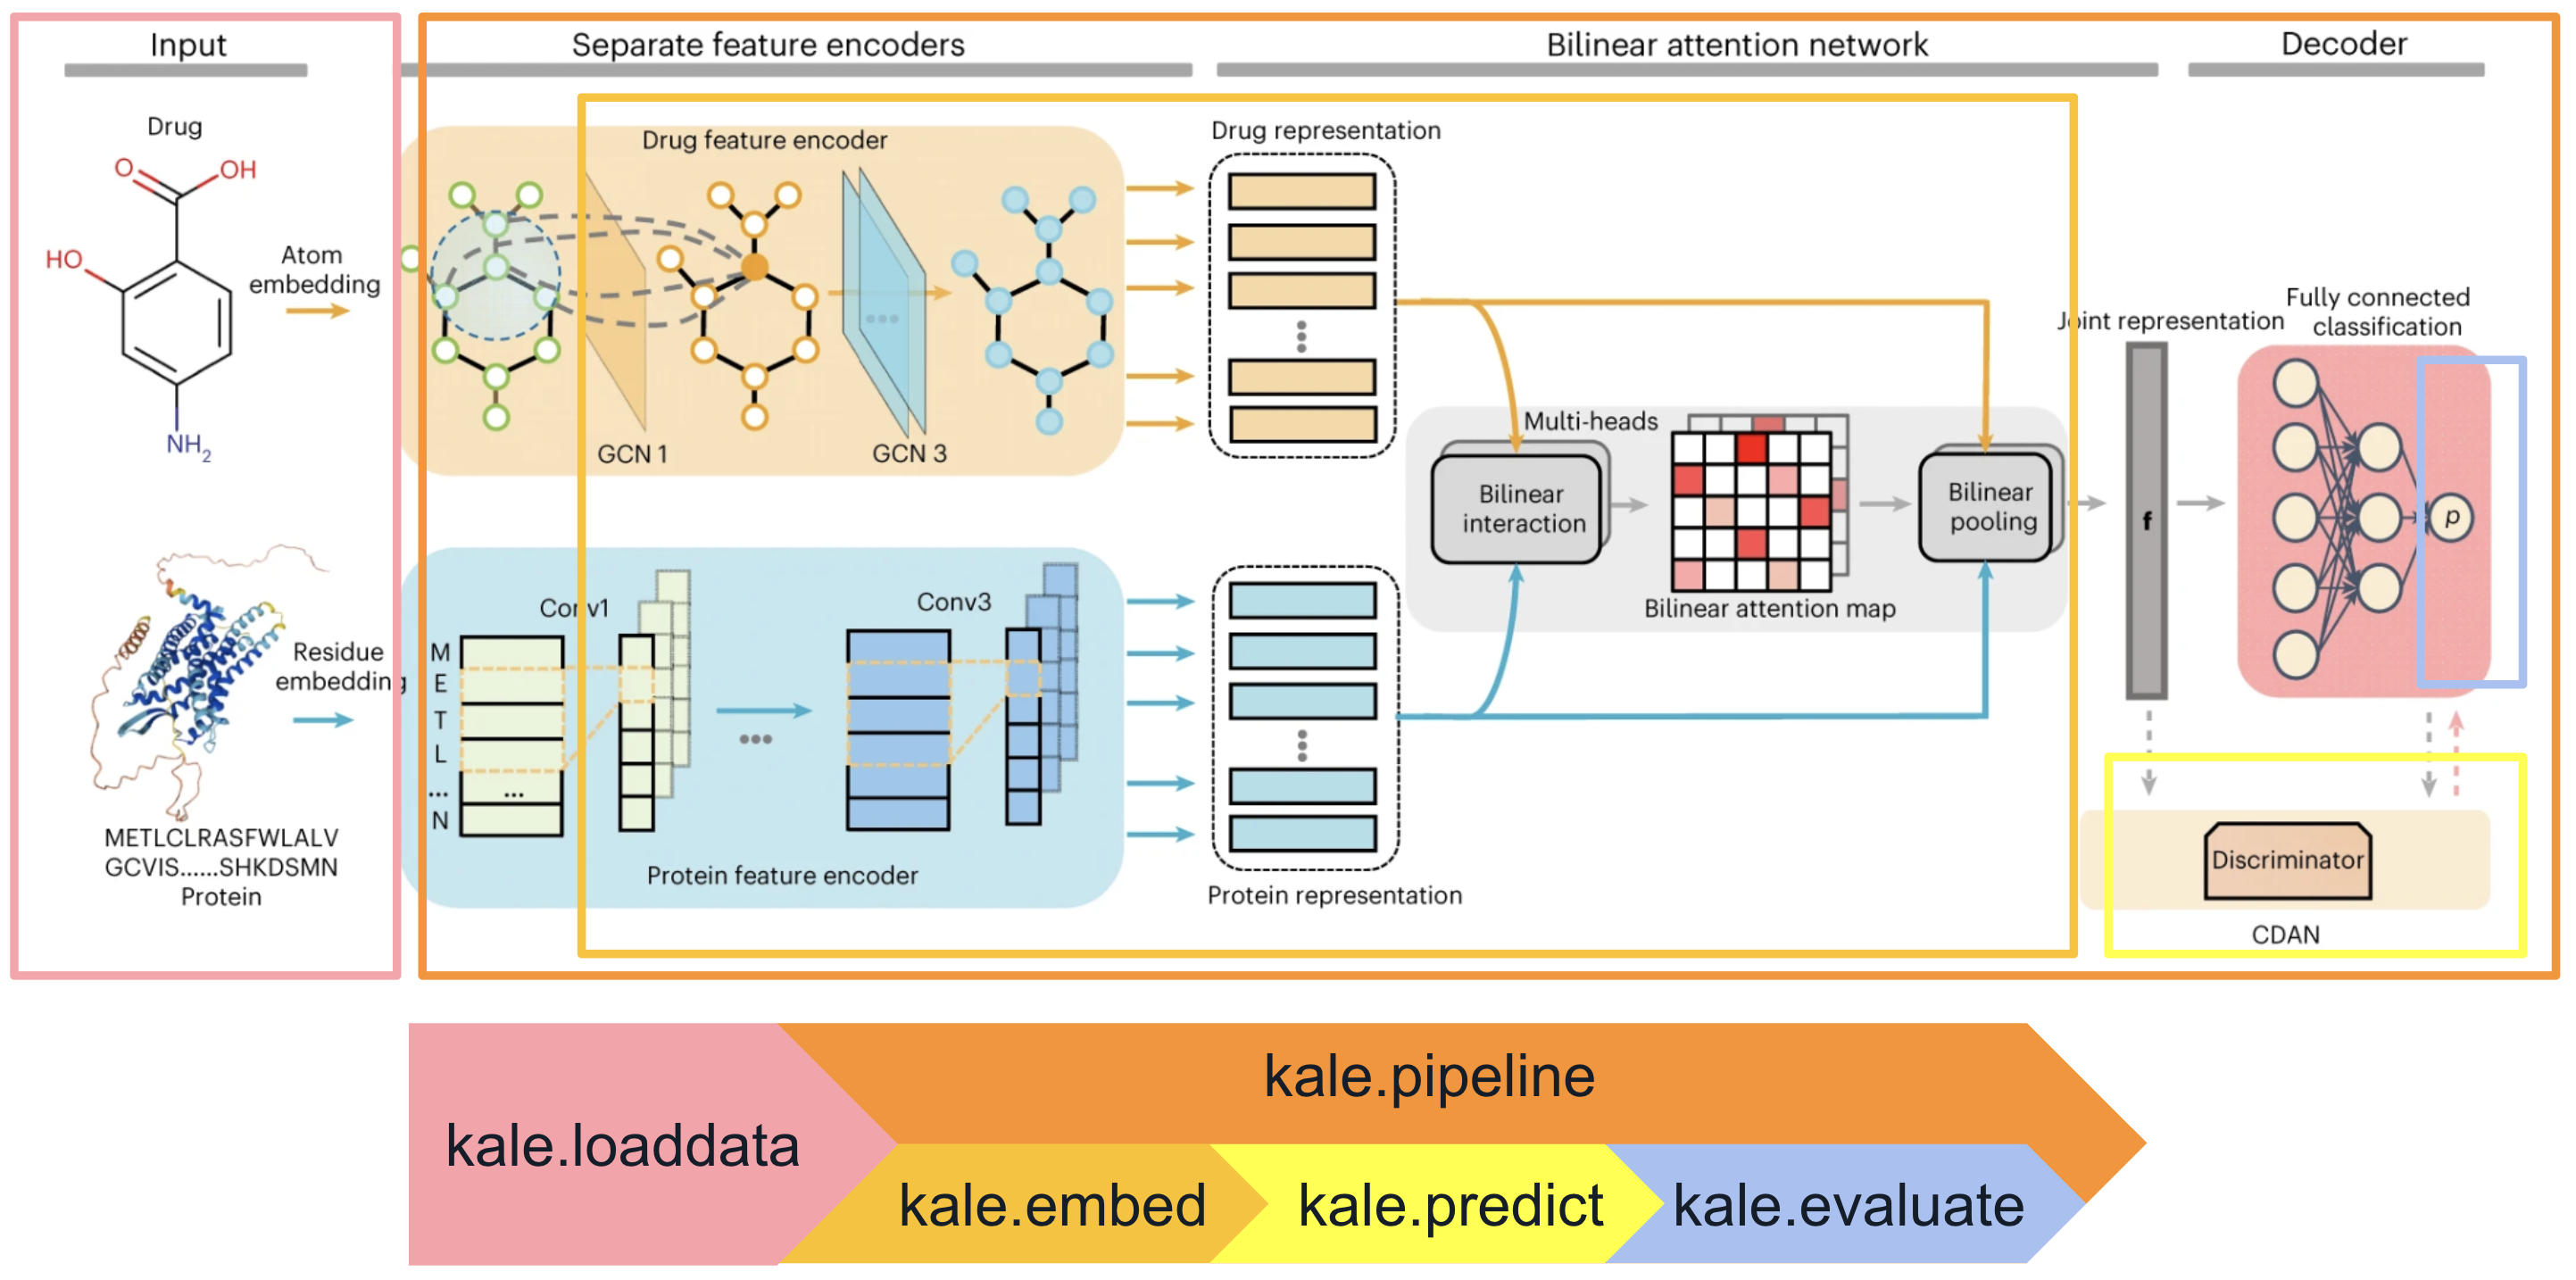
In this tutorial, we demonstrate the standard pipeline in `PyKale` and show how to integrate multimodal data from **drugs** and **proteins** to perform **drug-target interaction (DTI) prediction**.



This tutorial builds on the work of [**Bai et al. (_Nature Machine Intelligence_, 2023)**](https://www.nature.com/articles/s42256-022-00605-1), which introduced the **DrugBAN** framework. The DrugBAN includes two key ideas:

- A **bilinear attention network (BAN)**. This is a model that learns the features of both the drug and the protein, and how these features interact locally.


- **Adversarial domain adaptation**. This is a method that helps the model generalise to data that is different from what it was trained on (also known as out-of-distribution data), improving its performance on unseen drug–target pairs.


## Problem Formulation

This tutorial focuses on the drug–target interaction (DTI) prediction problem, which is framed as a binary classification task. The inputs are drug SMILES strings and protein amino acid sequences, and the output is a binary label (1 or 0) indicating whether an interaction occurs.

We will work with two datasets: **BioSNAP** and **BindingDB**. The main tutorial will use the BioSNAP dataset, while BindingDB is provided as an additional dataset for you to explore and reproduce results in your own time after completing the tutorial.

## Objective
- Understand the standard pipeline of `PyKale` library.


## Environment Preparation

As a starting point, we will install the required packages and load a set of helper functions to assist throughout this tutorial. To keep the output clean and focused on interpretation, we will also suppress warnings.

Moreover, we provide helper functions that can be inspected directly in the `.py` files located in the notebook's current directory. The additional helper script is:
- [`config.py`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/drug-target-interaction/configs.py): Defines the base configuration settings, which can be overridden using a custom `.yaml` file.

### Package Installation

The main packages required for this tutorial are **PyKale**, **PyTorch Geometric**, and **RDKit**.

- **PyKale** is an open-source interdisciplinary machine learning library developed at the University of Sheffield, designed for applications in biomedical and scientific domains.
- **PyG** (PyTorch Geometric) is a library built on top of PyTorch for building and training Graph Neural Networks (GNNs) on structured data.
- **RDKit** is a cheminformatics toolkit for handling and processing molecular structures, particularly useful for working with SMILES strings and molecular graphs.

Other required packages can be found in [`embc-mmai25/requirements.txt`](https://github.com/pykale/embc-mmai25/blob/main/requirements.txt).

--------------------------------------------------------------------------------

#### **WARNINGS**
Please don't re-run this session after installation completed. Runing this installation multiple times will trigger issues related to `PyG`. If you want to re-run this installation, please click the `Runtime` on the top menu and choose `Disconnect and delete runtime` before installing.


In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

!git clone https://github.com/pykale/embc-mmai25.git
%cd /content/embc-mmai25/tutorials/drug-target-interaction

!pip install --quiet -r /content/embc-mmai25/requirements.txt \
    && echo "Required packages installed successfully ✅" \
    || echo "Failed to install required packages ❌"

!pip install --quiet git+https://github.com/pykale/pykale@main\
    && echo "PyKale installed successfully ✅" \
    || echo "Failed to install PyKale ❌"

import torch
os.environ['TORCH'] = torch.__version__
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html

!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git \
    && echo "PyG installed successfully ✅" \
    || echo "Failed to install PyG ❌"

!pip install rdkit-pypi \
    && echo "PyG installed successfully ✅" \
    || echo "Failed to install PyG ❌"


# !pip install "numpy<2.0" "transformers==4.30.2" --force-reinstall --quiet
!pip install --upgrade --force-reinstall numpy==2.0.0
os.kill(os.getpid(), 9)

Cloning into 'embc-mmai25'...
remote: Enumerating objects: 1444, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 1444 (delta 111), reused 136 (delta 85), pack-reused 1251 (from 1)
Receiving objects: 100% (1444/1444), 15.80 MiB | 16.94 MiB/s, done.
Resolving deltas: 100% (752/752), done.
/content/embc-mmai25/tutorials/drug-target-interaction
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 104.0 

In [ ]:
# (Optional: Numpy version check) ✅ Now run this AFTER restarting runtime
import numpy as np

print("NumPy version:", np.__version__)  # should be <2.0

NumPy version: 2.0.0


### Mount Data (Optional)

If you are using Google Colab, please using the following codes to load necessary datasets.

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

shared_drives_path = (
    "/content/drive/Shared drives/EMBC-MMAI 25 Workshop/data/drug-target-interaction"
)

import os
import shutil

print("Contents of the folder:")
for item in os.listdir(shared_drives_path):
    print(item)

Mounted at /content/drive
Contents of the folder:
bindingdb
biosnap


### Configuration

To minimize the footprint of the notebook when specifying configurations, we provide a [`config.py`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/drug-target-interaction/configs.py) file that defines default parameters. These can be customized by supplying a `.yaml` configuration file, such as [`experiments/DA_cross_domain.yaml`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/drug-target-interaction/experiments/DA_cross_domain.yaml) as an example.

In this tutorial, we list the hyperparameters we would like users to play with outside the `.yaml` file:
- `cfg.SOLVER.MAX_EPOCH`: Number of epochs in training stage.
- `cfg.DATA.DATASET`: The dataset used in the study. This can be `bindingdb` or `biosnap`.

As a quick exercise, please take a moment to review and understand the parameters in [`config.py`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/drug-target-interaction/configs.py).

In [ ]:
%cd /content/embc-mmai25/tutorials/drug-target-interaction

from configs import get_cfg_defaults

# Load the default settings from config.py
cfg = get_cfg_defaults()

# Update (or override) some of those settings using a custom YAML file
cfg.merge_from_file("experiments/DA_cross_domain.yaml")

# ------ Hyperparameters to play with -----
# User can reduce the training epochs to decrease training time if necessary
cfg.SOLVER.MAX_EPOCH = 2

# User can change to a different dataset
cfg.DATA.DATASET = "biosnap"

# -----------------------------------------
print(cfg)

/content/embc-mmai25/tutorials/drug-target-interaction
BCN:
  HEADS: 2
COMET:
  API_KEY: 
  EXPERIMENT_NAME: DA_cross_domain
  PROJECT_NAME: drugban-23-May
  TAG: DrugBAN_CDAN
  USE: True
DA:
  INIT_EPOCH: 10
  LAMB_DA: 1
  METHOD: CDAN
  ORIGINAL_RANDOM: True
  RANDOM_DIM: 256
  RANDOM_LAYER: True
  TASK: True
  USE: True
  USE_ENTROPY: False
DATA:
  DATASET: biosnap
  SPLIT: cluster
DECODER:
  BINARY: 2
  HIDDEN_DIM: 512
  IN_DIM: 256
  NAME: MLP
  OUT_DIM: 128
DRUG:
  HIDDEN_LAYERS: [128, 128, 128]
  MAX_NODES: 290
  NODE_IN_EMBEDDING: 128
  NODE_IN_FEATS: 7
  PADDING: True
PROTEIN:
  EMBEDDING_DIM: 128
  KERNEL_SIZE: [3, 6, 9]
  NUM_FILTERS: [128, 128, 128]
  PADDING: True
RESULT:
  SAVE_MODEL: True
SOLVER:
  BATCH_SIZE: 32
  DA_LEARNING_RATE: 5e-05
  LEARNING_RATE: 0.0001
  MAX_EPOCH: 2
  NUM_WORKERS: 0
  SEED: 20


## Data Loading and Pre-processing

In this tutorial, we use a benchmark dataset called **Biosnap**, which contains information about how well different drugs interact with specific proteins. This dataset has been preprocessed and provided by the authors of the **DrugBAN** paper. You can also find it in their [GitHub repository](https://github.com/peizhenbai/DrugBAN/tree/main).

The Biosnap dataset is stored in a folder called `biosnap`, which contains a few subfolders. Each subfolder corresponds to a different experimental setting for training and testing machine learning models.

Here is a simplified view of the folder structure:



```sh
    ├───biosnap
    │   ├───cluster
    │   │   ├───source_train.csv
    │   │   ├───target_train.csv
    │   │   ├───target_test.csv
    │   ├───random
    │   │   ├───test.csv
    │   │   ├───train.csv
    │   │   ├───val.csv
    │   ├───full.csv

```


Each file listed here is in **CSV format**, which you can open using spreadsheet software (like Excel) or load into Python using tools like `pandas`. These files contain rows of data, with each row representing one drug–protein pair.


Here’s what each csv file looks like in a table format:

| SMILES             | Protein Sequence         | Y |
|--------------------|--------------------------|---|
| Fc1ccc(C2(COC…)    | MDNVLPVDSDLS…            | 1 |
| O=c1oc2c(O)c(…)    | MMYSKLLTLTTL…            | 0 |
| CC(C)Oc1cc(N…)     | MGMACLTMTEME…            | 1 |

Each row of the dataset contains three key pieces of information:

**Drugs**:  
Drugs are often written as SMILES strings, which are like chemical formulas in text format (for example, `"CC(=O)OC1=CC=CC=C1C(=O)O"` is aspirin).  


**Protein Sequence**  
This is a string of letters where each letter stands for an amino acid, the building blocks of proteins. For example, `MGYTSLLT...` is a short protein sequence.


**Y (Labels)**:  
Each drug–protein pair is given a label:
- `1` if they interact
- `0` if they do not


Each row shows one drug–protein pair. The goal of our machine learning model is to predict the last column (**Y**) — whether or not the drug and protein interact.



To generate the drug graphs, we use the `kale.loaddata.molecular_datasets.smiles_to_graph` function, which converts SMILES strings into graph structures. For each molecule, atom-level features such as atomic number, degree, valence, and aromaticity are encoded as node features. Bond information is represented through edge indices and edge attributes. The function automatically adds self-loops to all nodes to ensure that each node has at least one connection. For molecules with fewer atoms than the maximum allowed, the function applies node padding by adding virtual nodes with zero features.


We use the kale.prepdata.`chem_transform.integer_label_protein` function to convert protein sequences into fixed-length integer arrays. Each amino acid is mapped to a unique integer based on a predefined dictionary (CHARPROTSET). Sequences longer than the maximum length (default: 1200) are truncated, while shorter sequences are zero-padded. Unknown characters are treated as padding, ensuring all protein inputs have a consistent numerical format.


We then use the `kale.loaddata.molecular_datasets.DTIDataset` class to integrate these steps by organising the drug-protein-label triplets into a dataset format compatible with PyTorch. During training and evaluation, the DataLoader calls graph_collate_func to batch the molecular graphs, protein sequences, and labels into a single batch. The output is a batched drug graph, a stacked protein sequence tensor, and a label tensor, ready for input into the DrugBAN model.

In [ ]:
from kale.loaddata.molecular_datasets import DTIDataset
import pandas as pd

# Path to the dataset folder
dataFolder = os.path.join(
    f"/content/drive/Shared drives/EMBC-MMAI 25 Workshop/data/drug-target-interaction/{cfg.DATA.DATASET}",
    str(cfg.DATA.SPLIT),
)

# Path to the dataset folder
df_train_source = pd.read_csv(os.path.join(dataFolder, "source_train.csv"))
df_train_target = pd.read_csv(os.path.join(dataFolder, "target_train.csv"))
df_test_target = pd.read_csv(os.path.join(dataFolder, "target_test.csv"))

# Create preprocessed datasets
train_dataset = DTIDataset(df_train_source.index.values, df_train_source)
train_target_dataset = DTIDataset(df_train_target.index.values, df_train_target)
test_target_dataset = DTIDataset(df_test_target.index.values, df_test_target)

/usr/local/lib/python3.11/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  import torch_geometric.typing
/usr/local/lib/python3.11/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  import torch_geometric.typing


### Dataset Inspection

Once we’ve loaded the dataset, it's useful to take a quick look at what it contains. This helps us understand the data format and what kind of information we’ll be working with in the rest of the tutorial.

In this project, our dataset has been split into three parts:

**Train samples from the source domain**  
These are drug–protein pairs the model will learn from. The "source domain" typically refers to a distribution of data that the model is familiar with.

**Train samples from the target domain**  
These are additional training samples, but from a different distribution (a "target domain") the model should generalise to. This helps simulate real-world scenarios where new data may come from different conditions.

**Test samples from the target domain**  
These are drug–protein pairs that the model has never seen before, and they’re used to evaluate how well the model generalises to new, unseen cases.

Let’s print out the number of samples in each set, and take a peek at one example from the training data.


In [ ]:
print(
    f"Train samples from source domain: {len(train_dataset)}, Train samples from target domain: {len(train_target_dataset)}, Test samples from target domain: {len(test_target_dataset)}"
)

print("\nAn example sample from source domain:")
print(train_dataset[0])

Train samples from source domain: 9766, Train samples from target domain: 3628, Test samples from target domain: 907

An example sample from source domain:
(Data(x=[290, 7], edge_index=[2, 58], edge_attr=[58, 1], num_nodes=290), array([11.,  1., 18., ...,  0.,  0.,  0.]), np.float64(0.0))


Let’s break down what this example from the **source domain** means:

```
An example sample from source domain:
(Data(x=[290, 7], edge_index=[2, 58], edge_attr=[58, 1], num_nodes=290), array([11.,  1., 18., ...,  0.,  0.,  0.]), 0.0)
```

This sample is a tuple with **three parts**:



1. **Drug Graph (Data object)**

This part is a graph-based representation of the **drug**, built using the PyTorch Geometric `Data` object:

- `x=[290, 7]`  
  This is a table (matrix) with **290 nodes** (atoms) and **7 features** per atom.  
  Each row represents an atom, and each column describes one feature of the atom.

- `edge_index=[2, 58]`  
  This shows how the atoms are connected (like chemical bonds).  
  There are **58 edges**, and the matrix has 2 rows — the first row lists source atoms, the second lists the target atoms.

- `edge_attr=[58, 1]`  
  Each edge (bond) has **1 feature**, such as bond type.  
  So there are 58 rows (one for each edge), and 1 column.

- `num_nodes=290`  
  This confirms that the graph has **290 atoms (nodes)**.



2. **Protein Features (array)**

- This is a **1D array** (or vector) representing the **protein**.  
- It contains numerical features extracted from the protein sequence or structure.  
- Example values: `[11.,  1., 18., ...,  0.,  0.,  0.]`  
  These could represent biochemical or structural properties, with padding at the end (zeros) to ensure a consistent input size.


3. **Label (float)**

- `0.0`  
  This is the **label**, which tells us the ground truth:  
  The drug and protein **do not interact** in this sample.  

  If the label were `1.0`, it would mean they **do interact**.



This format allows the model to learn from both structured graph data (the drug) and feature-based data (the protein), and predict whether they interact based on the label.


### Batching

When training machine learning models, especially on large datasets like molecular graphs, it’s inefficient and memory-intensive to load everything at once. Instead, we split the data into **mini-batches** and feed them into the model one at a time. This process is called **batching**, i.e, loading data in manageable pieces.

We use PyTorch’s `DataLoader` to efficiently batch and load samples during training and evaluation. For training, we create two separate data loaders: one for the source domain and one for the target domain. To enable domain adaptation, we combine them using `kale.loaddata.sampler.MultiDataLoader`, which yields one batch from each domain at every training step and ensures a consistent number of batches per epoch by automatically restarting smaller datasets when needed.

However, because molecular data involves graphs of varying sizes and structures, we cannot stack them like regular tensors or images. To handle this, we use a custom collate function called `kale.loaddata.molecular_datasets.graph_collate_func`, which tells the `DataLoader` how to correctly combine multiple graphs into a single batch that the model can process.

In [ ]:
from torch.utils.data import DataLoader
from kale.loaddata.molecular_datasets import graph_collate_func
from kale.loaddata.sampler import MultiDataLoader

# Define the parameters used by the data loaders
params = {
    "batch_size": cfg.SOLVER.BATCH_SIZE,  # Number of samples per batch
    "shuffle": True,  # Shuffle data during training
    "num_workers": cfg.SOLVER.NUM_WORKERS,  # Number of workers loading the data
    "drop_last": True,  # Drop the last batch if it's smaller than batch_size
    "collate_fn": graph_collate_func,  # Custom function to batch graphs correctly
}


# Create data loaders for source and target training datasets
source_generator = DataLoader(train_dataset, **params)
target_generator = DataLoader(train_target_dataset, **params)

# Get the number of batches in the longer dataset to align both
n_batches = max(len(source_generator), len(target_generator))

# Combine the source and target data loaders using MultiDataLoader
training_generator = MultiDataLoader(
    dataloaders=[source_generator, target_generator], n_batches=n_batches
)  # used to be named as multi_generator


# Now we set up data loaders for validation and testing. Since we don’t want to shuffle or drop any samples, we adjust the parameters accordingly.

# Update parameters for validation/testing (no shuffling, keep all data)
params.update({"shuffle": False, "drop_last": False})

# Create validation and test data loaders
valid_generator = DataLoader(test_target_dataset, **params)
test_generator = DataLoader(test_target_dataset, **params)

## Model Definition

DrugBAN consists of three main components: a Graph Convolutional Network (GCN) for extracting structural features from drug molecular graphs, a Convolutional Neural Network (CNN) for encoding protein sequences, and a Bilinear Attention Network (BAN) for fusing drug and protein features. The fused representation is then passed through a Multi-Layer Perceptron (MLP) classifier to predict interaction scores.

We define the DrugBAN class in `kale.embed.ban`, which wraps all key modules of the DrugBAN pipeline based on the configuration.
This wrapper handles:

- Initialising the GCN-based drug feature extractor (MolecularGCN).

- Building the CNN-based protein sequence encoder (ProteinCNN).

- Integrating the BAN layer for drug-protein feature fusion (BANLayer).

- Creating the MLP classifier for final prediction (MLPDecoder).

In [ ]:
from kale.embed.ban import DrugBAN

# Create the model using settings from your config
model = DrugBAN(**cfg)

# Print the model structure to see what's inside
print(model)

## Model Training
We use the training class `kale.pipeline.drugban_trainer`, which handles model training, domain adaptation, and evaluation for DrugBAN.

In [ ]:
from kale.pipeline.drugban_trainer import DrugbanTrainer

# Create an instance of the trainer with your model and configuration
drugban_trainer = DrugbanTrainer(
    model=DrugBAN(**cfg),
    solver_lr=cfg["SOLVER"]["LEARNING_RATE"],
    num_classes=cfg["DECODER"]["BINARY"],
    batch_size=cfg["SOLVER"]["BATCH_SIZE"],
    # Domain adaptation settings
    is_da=cfg["DA"]["USE"],
    solver_da_lr=cfg["SOLVER"]["DA_LEARNING_RATE"],
    da_init_epoch=cfg["DA"]["INIT_EPOCH"],
    da_method=cfg["DA"]["METHOD"],
    original_random=cfg["DA"]["ORIGINAL_RANDOM"],
    use_da_entropy=cfg["DA"]["USE_ENTROPY"],
    da_random_layer=cfg["DA"]["RANDOM_LAYER"],
    # --- discriminator parameters ---
    da_random_dim=cfg["DA"]["RANDOM_DIM"],
    decoder_in_dim=cfg["DECODER"]["IN_DIM"],
)

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


We want to save the best model during training so we can reuse it later without needing to retrain. PyTorch Lightning’s `ModelCheckpoint` does this by automatically saving the model whenever it achieves a new best validation AUROC score.

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

# Save the model when it achieves the best AUROC score on the validation set
checkpoint_callback = ModelCheckpoint(
    filename="{epoch}-{step}-{val_BinaryAUROC:.4f}",  # how to name saved files
    monitor="val_BinaryAUROC",  # which metric to monitor
    mode="max",  # we want to maximise this score
)

We now create the `Trainer`.

In [ ]:
import torch

trainer = pl.Trainer(
    callbacks=[checkpoint_callback],  # automatically save best model
    devices="auto",  # use all available GPUs
    accelerator=(
        "gpu" if torch.cuda.is_available() else "cpu"
    ),  # decide training hardware
    max_epochs=cfg["SOLVER"]["MAX_EPOCH"],  # how many passes over the training set
    deterministic=True,  # makes results reproducible every time you run
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Train the DrugBAN Model
After setting up the model and data loaders, we now start training the full DrugBAN model using the PyTorch Lightning Trainer via calling `trainer.fit()`.

#### What Happens Here?
- The model receives batches of drug-protein pairs from the training data loader.

- During each step, the GCN, CNN, BAN layer, and MLP classifier are updated to improve interaction prediction.

- Validation is automatically run at the end of each epoch to track performance and save the best model based on AUROC.

In [ ]:
trainer.fit(
    drugban_trainer,
    train_dataloaders=training_generator,
    val_dataloaders=valid_generator,
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type                | Params | Mode 
---------------------------------------------------------------------
0 | model                | DrugBAN             | 1.0 M  | train
1 | domain_discriminator | DomainNetSmallImage | 133 K  | train
2 | random_layer         | RandomLayer         | 66.0 K | train
3 | valid_metrics        | MetricCollection    | 0      | train
4 | test_metrics         | MetricCollection    | 0      | train
---------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.847     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 9280. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: TorchMetricsUserWarning: You are trying to use a metric in deterministic mode on GPU that uses `torch.cumsum`, which is currently not supported. The tensor will be copied to the CPU memory to compute it and then copied back to GPU. Expect some slowdowns.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

[15:53:49] Unusual charge on atom 0 number of radical electrons set to zero
[15:53:55] Unusual charge on atom 0 number of radical electrons set to zero


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3190. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
[15:54:38] Unusual charge on atom 0 number of radical electrons set to zero
[15:55:25] Unusual charge on atom 0 number of radical electrons set to zero


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


### Evaluate

Once training is complete, we evaluate the model on the test set using `trainer.test()`.

#### What is included in this step?
- The best model checkpoint (based on validation AUROC) is automatically loaded.

- The model runs on the test data to generate predictions.

- Final classification metrics, including AUROC, F1 score, accuracy, sensitivity, and specificity, are calculated and logged.

In [ ]:
trainer.test(drugban_trainer, dataloaders=test_generator, ckpt_path="best")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/embc-mmai25/tutorials/drug-target-interaction/lightning_logs/version_0/checkpoints/epoch=1-step=1220-val_BinaryAUROC=0.5640.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/embc-mmai25/tutorials/drug-target-interaction/lightning_logs/version_0/checkpoints/epoch=1-step=1220-val_BinaryAUROC=0.5640.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/kale/pipeline/drugban_trainer.py:377: RuntimeWarning: invalid value encountered in divide
  precision = tpr / (tpr + fpr)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: TorchMetricsUserWarning: You are trying to use a metric in deterministic mode on GPU that uses `torch.cumsum`, which is currently not supported. The tensor will be copied to the CPU memory to compute it and then copied back to GPU. Expect some slowdowns.
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_BinaryAUROC      │    0.5640328526496887     │
│    test_BinaryAccuracy    │    0.5082690119743347     │
│    test_BinaryF1Score     │    0.15209124982357025    │
│     test_BinaryRecall     │    0.08791209012269974    │
│  test_BinarySpecificity   │    0.9314159154891968     │
│   test_accuracy_sklearn   │    0.5226019620895386     │
│    test_auroc_sklearn     │    0.5640328526496887     │
│      test_f1_sklearn      │    0.6693024635314941     │
│         test_loss         │    0.8550940155982971     │
│   test_optim_threshold    │    0.08681917190551758    │
│     test_sensitivity      │    0.07300885021686554    │
│     test_specificity      │    0.9692307710647583     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8550940155982971,
  'test_auroc_sklearn': 0.5640328526496887,
  'test_accuracy_sklearn': 0.5226019620895386,
  'test_f1_sklearn': 0.6693024635314941,
  'test_sensitivity': 0.07300885021686554,
  'test_specificity': 0.9692307710647583,
  'test_optim_threshold': 0.08681917190551758,
  'test_BinaryAUROC': 0.5640328526496887,
  'test_BinaryF1Score': 0.15209124982357025,
  'test_BinaryRecall': 0.08791209012269974,
  'test_BinarySpecificity': 0.9314159154891968,
  'test_BinaryAccuracy': 0.5082690119743347}]

### Compare with Baselines

To assess the robustness and generalisability of DrugBAN, we compare its performance against baseline models. In this example, DrugBAN was trained for 100 epochs across multiple random seeds。

The figure below presents the comparison on the BioSNAP and BindingDB datasets.

- The left plot shows model performance based on AUROC (Area Under the Receiver Operating Characteristic Curve).

- The right plot shows performance based on AUPRC (Area Under the Precision–Recall Curve).

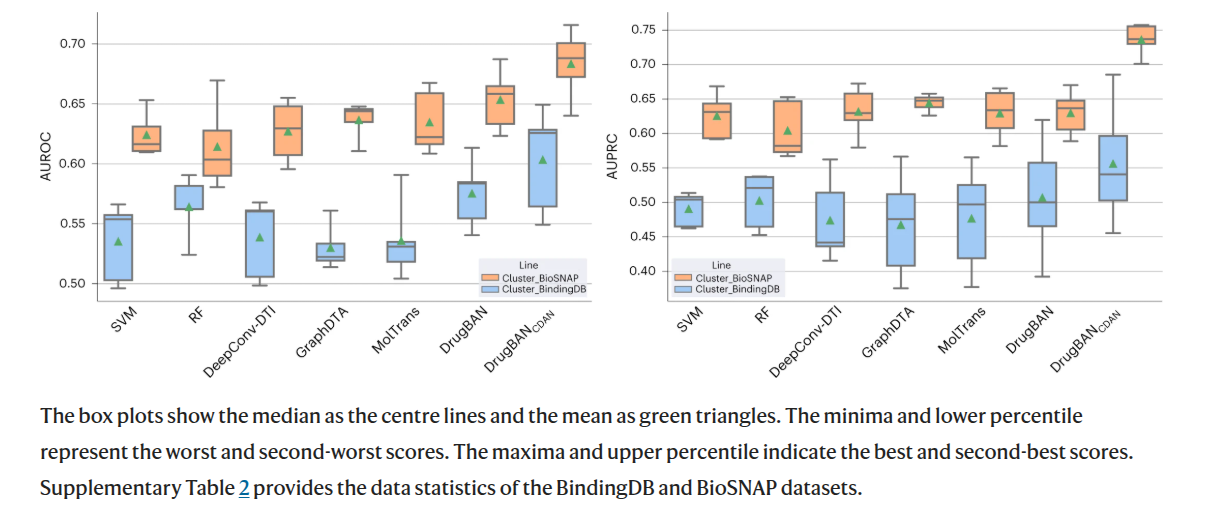

## Interpretation Study - Extracting Embeddings from DrugBAN
After training and evaluating the model, we can study how DrugBAN represents drug and protein information at different stages by extracting key embeddings: **drug embedding**, **protein embedding**, and **joint interaction embedding**. This helps us understand how structural and sequential features are captured and how drug-protein interactions are encoded.

The DrugBAN model provides these embeddings through its `forward()` function, returning intermediate outputs before and after the Bilinear Attention Network (BAN) layer.

### How Are the Embeddings Computed?
The `forward()` function sequentially applies three main modules:

- The **GCN-based drug extractor** processes the molecular graph, learning structural features and generating the **drug embedding**.

- The **CNN-based protein extractor** processes the protein sequence, capturing local and global sequence patterns as the **protein embedding**.

- The **BAN layer** fuses the drug and protein embeddings using bilinear attention, creating a **joint embedding** that highlights interaction-specific features.

You should save embeddings during the evaluation phase (validation or test), not during training. This ensures you are extracting embeddings from a model that is not updating its weights, and you avoid interfering with training performance.

## Extra Tasks

### Task 1: Try the BindingDB Dataset
Swap the current dataset with **BindingDB**, a real-world dataset containing experimentally measured drug–target interactions.

Steps:
1. Download or prepare the BindingDB dataset (if needed).
2. Update the relevant field in the YAML config file.
3. Reload the dataset and re-run training and testing.

**What to explore:**
- Does model performance change?
- Is the dataset more imbalanced?
- How does training time compare?

> Tip: See if the model struggles more or less with the new dataset. It can reveal how generalisable DrugBAN is.

